In [1]:
import numpy as np
import json

def openLists(route):
    val = {}
    with open(f'{route}') as file:
        for line in file:
            data = json.loads(line)
            key, values = data
            val[key] = np.array(values)
        return val
    

archivo = openLists('listas-posteo-100.json')

In [2]:
import random
import itertools
listas = list(archivo.values())
# Generamos todas las posibles combinaciones de 3 listas
def generar_combinaciones(listas, n):
    return itertools.combinations(listas, n)

# Seleccionamos aleatoriamente 1000 combinaciones
combinaciones = generar_combinaciones(listas, 2)
A = random.sample(list(combinaciones), 1000)
combinaciones = generar_combinaciones(listas, 3)
B = random.sample(list(combinaciones), 1000)
combinaciones = generar_combinaciones(listas, 4)
C = random.sample(list(combinaciones), 1000)

#print(B)  # Imprime las 1000 combinaciones seleccionadas

In [3]:
def binary_search(arr, x):
  low = 0
  high = len(arr) - 1

  while low <= high:
    mid = (low + high) // 2
    if arr[mid] == x:
      return mid
    elif arr[mid] < x:
      low = mid + 1
    else:
      high = mid - 1

  return -1

In [4]:
import time

def SvS(sets, k, fbusq):
  start_time = time.process_time()
  comparisons = 0

  # 1. Ordenar los conjuntos por tamaño
  sets.sort(key=len)

  # 2. El conjunto más pequeño es el candidato inicial
  candidate_set = sets[0].copy()

  # 3. Inicializar índices
  indices = [0] * k

  # 4. Iterar sobre los conjuntos
  for i, S in enumerate(sets):
    for e in list(candidate_set):
      # 6. Búsqueda binaria redondeada
      index = fbusq(S[indices[i]:], e)
      comparisons += 1
      if index != -1:
        indices[i] += index + 1
      else:
        # 8-10. Eliminar e del conjunto candidato
        candidate_set.remove(e)
  end_time = time.process_time()
  elapsed_time = end_time - start_time


  return candidate_set, comparisons, elapsed_time

# Ejemplo de uso:
sets = [[1, 2, 3, 4], [3, 4, 9, 10], [3, 4, 5, 6, 7], [3, 4, 11, 12]]
k = len(sets)
result, comparaciones, tiempo = SvS(sets, k, binary_search)
print(result)  # Output: {3, 4}
print(comparaciones)
print(tiempo)

[3, 4]
12
5.600000000027805e-05


In [5]:
def starter(listas, busqueda, interseccion, combs):
    flist = []
    ftime = []
    fcomp = []
    for element in listas:
        if combs == 2:
            lista1 = element[0].tolist()
            lista2 = element[1].tolist()
            listafinal = [lista1, lista2,]
        if combs == 3:
            lista1 = element[0].tolist()
            lista2 = element[1].tolist()
            lista3 = element[2].tolist()
            listafinal = [lista1, lista2, lista3]
        if combs == 4:
            lista1 = element[0].tolist()
            lista2 = element[1].tolist()
            lista3 = element[2].tolist()
            lista4 = element[3].tolist()
            listafinal = [lista1, lista2, lista3, lista4]
        k = len(listafinal)
        result, comparaciones, tiempo = interseccion(listafinal, k, busqueda)
        flist.append(result)
        flist = [sublist for sublist in flist if sublist] #Eliminamos las listas vacías
        ftime.append(tiempo)
        fcomp.append(comparaciones)
        64808
    return flist, ftime, fcomp


In [6]:
listABS_A, timeABS_A, compABS_A = starter(A, binary_search, SvS, 2)
listABS_B, timeABS_B, compABS_B = starter(B, binary_search, SvS, 3)
listABS_C, timeABS_C, compABS_C = starter(C, binary_search, SvS, 4)

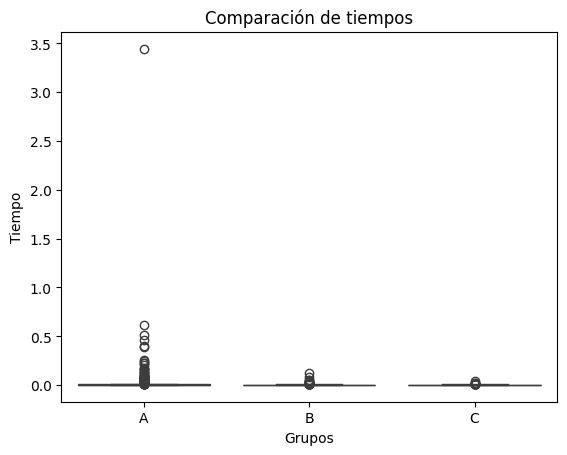

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

data = [timeABS_A, timeABS_B, timeABS_C]

sns.boxplot(data=data)
plt.xticks([0, 1, 2], ['A', 'B', 'C'])
plt.title('Comparación de tiempos')
plt.xlabel('Grupos')
plt.ylabel('Tiempo')
plt.show()

In [8]:
def SmallAdaptive(sets, k, fbusq):
  start_time = time.process_time()
  comparisons = 0
  answer = []

  # Mientras haya algún conjunto no vacío
  while any(sets):
    # 2. Ordenar los conjuntos por tamaño creciente
    sets.sort(key=len)
    # 3. Seleccionar el primer elemento del conjunto más pequeño como eliminador
    if sets[0]:
        eliminator = sets[0].pop(0)
    else:
        # Si el conjunto está vacío, pasamos al siguiente conjunto
        break

    # 4. Inicializar el índice del conjunto a 1
    elimset = 1

    # 5. Iterar mientras no se hayan revisado todos los conjuntos o se encuentre el eliminador k veces
    while elimset < k and eliminator in sets[elimset]:
      # 6. Búsqueda binaria adaptada para encontrar el eliminador en el conjunto actual
      index = fbusq(sets[elimset], eliminator)
      comparisons += 1
      if index != -1:
        # Eliminar el elemento encontrado y desplazar los elementos restantes
        sets[elimset].pop(index)
      elimset += 1

    # 9. Si se encontró el eliminador en k conjuntos, agregarlo al conjunto de respuestas
    if elimset == k:
      answer.append(eliminator)

  end_time = time.process_time()
  elapsed_time = end_time - start_time

  return answer, comparisons, elapsed_time


sets = [[1, 2, 3, 4], [3, 4, 9, 10], [3, 4, 5, 6, 7], [3, 4, 11, 12]]
k = len(sets)
result, comparaciones, tiempo = SmallAdaptive(sets, k, binary_search)
print(result)  # Output: {3, 4}
print(comparaciones)
print(tiempo)

[3, 4]
6
2.6999999999333113e-05


In [9]:
listABS_A, timeABS_A, compABS_A = starter(A, binary_search, SvS, 2)
listABS_A1, timeABS_A1, compABS_A1 = starter(A, binary_search, SmallAdaptive, 2)
if listABS_A == listABS_A1:
    print("True")


True


In [10]:
from bisect import bisect_right

def succ(arr, element):

    index = bisect_right(arr, element)
    if index < len(arr):
        return arr[index]
    else:
        return None

def Sequential(sets, k, fbusq):
    start_time = time.process_time()
    comparisons = 0
    answer = []

    # 1. Elegir un eliminador inicial y el conjunto inicial
    eliminator = sets[0][0]
    elimset = 0

    # 2. Iterar mientras el eliminador no sea un valor especial (e.g., None)
    while eliminator is not None:
        occurrence_counter = 0

        # 3. Buscar el eliminador en el conjunto actual
        index = fbusq(sets[elimset], eliminator)
        comparisons += 1

        # 4. Si se encuentra el eliminador, incrementar el contador de ocurrencias
        if index != -1:
            occurrence_counter += 1

            # 5. Si el contador de ocurrencias es igual a k, agregar el eliminador a la respuesta
            if occurrence_counter == k:
                answer.append(eliminator)

        # 6. Actualizar eliminador al siguiente elemento o a None si no se encuentra
        if index == -1 or occurrence_counter == k:
            eliminator = succ(sets[elimset], eliminator)

        # 7. Pasar al siguiente conjunto en orden cíclico
        elimset = (elimset + 1) % k

    end_time = time.process_time()
    elapsed_time = end_time - start_time

    return answer, comparisons, elapsed_time

sets = [[1, 2, 3, 4], [3, 4, 9, 10], [3, 4, 5, 6, 7], [3, 4, 11, 12]]
k = len(sets)
result, comparaciones, tiempo = Sequential(sets, k, binary_search)
print(result)  # Output: {3, 4}
print(comparaciones)
print(tiempo)

KeyboardInterrupt: 